In [1]:
import os
from pathlib import Path
from datetime import datetime
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', 500)

from build_dataset import create_tile, calc_tile_offsets
from build_dataset import compute_pixel_scale, coord2px, inside_tile
from build_dataset import get_files_from_folder, extract_dates_pattern_airmass_rgb_20200101_0000
from build_dataset import labeled_tiles_from_metadatafiles, get_tile_labels

from medicane_utils.load_files import load_cyclones_track_noheader
from medicane_utils.geo_const import latcorners, loncorners, x_center, y_center, basemap_obj

from view_test_tiles import plot_image, draw_tiles_and_center, create_gif_pil


/home/isac/miniconda3/envs/videomae/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Carico i cicloni

In [33]:
tracks_file = "./TRACKS_CL7.dat"  
df_tracks = load_cyclones_track_noheader(tracks_file)
df_tracks['time'] = pd.to_datetime(df_tracks['time'])
df_tracks.shape

(139135, 4)

In [34]:
df_tracks = df_tracks[df_tracks['time'] > datetime(2011, 1, 1)]
df_tracks.shape

(34584, 4)

In [35]:
tracks_df_coord = df_tracks[
    (df_tracks['lat'] >= latcorners[0]) & (df_tracks['lat'] <= latcorners[1]) &
    (df_tracks['lon'] >= loncorners[0]) & (df_tracks['lon'] <= loncorners[1])
]
tracks_df_coord.shape

(27318, 4)

In [6]:
df_med = pd.read_csv('medicane_validi.csv')
df_med['Start_Date'] = pd.to_datetime(df_med['Start_Date'])
df_med['End_Date'] = pd.to_datetime(df_med['End_Date'])
df_med


Unnamed: 0  Medicane Start_Date   End_Date
0            1      Rolf 2011-11-03 2011-11-09
1            3     Ilona 2014-01-19 2014-01-22
2            4  Qendresa 2014-11-04 2014-11-11
3            5    Trixie 2016-10-26 2016-11-02
4            6      Numa 2017-11-14 2017-11-20
5            7    Zorbas 2018-09-25 2018-10-01
6            8     Ianos 2020-09-14 2020-09-22
7           10    Apollo 2021-10-24 2021-11-02
8           11      Blas 2021-11-06 2021-11-16
9           12    Helios 2023-02-08 2023-02-11
10          13  Juliette 2023-02-25 2023-03-04
11          14    Daniel 2023-09-04 2023-09-11

In [37]:
# Partiamo da una colonna vuota
tracks_df_coord['Medicane'] = None

# Per ogni intervallo nel df_piccolo, assegna il nome alle righe che rientrano
for i, row in df_med.iterrows():
    start = row['Start_Date']
    end = row['End_Date'] + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)  # include tutto il giorno finale
    nome = row['Medicane']
    print(start, end, nome, end=' ')
    
    m_start = tracks_df_coord['time'] >= start
    m_end = tracks_df_coord['time'] <= end
    mask = m_start & m_end
    #print(m_start.sum(), m_end.sum(), mask.sum())
    #display(tracks_df_coord[mask])
    tracks_df_coord.loc[mask, 'Medicane'] = nome

2011-11-03 00:00:00 2011-11-09 23:59:59 Rolf 2014-01-19 00:00:00 2014-01-22 23:59:59 Ilona 2014-11-04 00:00:00 2014-11-11 23:59:59 Qendresa 2016-10-26 00:00:00 2016-11-02 23:59:59 Trixie 2017-11-14 00:00:00 2017-11-20 23:59:59 Numa 2018-09-25 00:00:00 2018-10-01 23:59:59 Zorbas 2020-09-14 00:00:00 2020-09-22 23:59:59 Ianos 2021-10-24 00:00:00 2021-11-02 23:59:59 Apollo 2021-11-06 00:00:00 2021-11-16 23:59:59 Blas 2023-02-08 00:00:00 2023-02-11 23:59:59 Helios 2023-02-25 00:00:00 2023-03-04 23:59:59 Juliette 2023-09-04 00:00:00 2023-09-11 23:59:59 Daniel 

In [38]:
tracks_df_coord[~tracks_df_coord['Medicane'].isna()]['Medicane'].unique()

array(['Rolf', 'Ilona', 'Qendresa', 'Trixie', 'Numa', 'Zorbas', 'Ianos'],
      dtype=object)

In [39]:
tracks_df_coord['year'] = tracks_df_coord['time'].dt.year
tracks_df_coord['month']= tracks_df_coord['time'].dt.month
tracks_df_coord['day']  = tracks_df_coord['time'].dt.day
tracks_df_coord['hour'] = tracks_df_coord['time'].dt.hour

### Leggo i file immagine

In [40]:
input_dir = "../fromgcloud"
#output_dir = "../airmassRGB/supervised" 
#os.makedirs(output_dir, exist_ok=True)

filenames = get_files_from_folder(folder=input_dir, extension="png")
#print(f"Trovati {len(filenames)} files")

file_metadata = []
for fname in filenames:
    start_dt = extract_dates_pattern_airmass_rgb_20200101_0000(fname.name)
    file_metadata.append((fname, start_dt))

sorted_files = sorted(file_metadata, key=lambda x: x[1])  # Ordina per start_dt
#random_fnames =  [item[0] for item in file_metadata]
sorted_filenames = [item[0] for item in sorted_files]
print(f" Ci sono {len(sorted_filenames)} files.")

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7ff04d0e74c0>>
Traceback (most recent call last):
  File "/home/isac/miniconda3/envs/videomae/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


 Ci sono 117764 files.


In [ ]:
fsel = [f for f in file_metadata if f[1] == datetime(2020, 9, 17, 3, 40)]
fsel_trixie = [f for f in file_metadata if f[1] == datetime(2016, 10, 30, 13, 40)]
fsel_rolf = [f for f in file_metadata if f[1] == datetime(2011, 11, 5, 12, 40)]

In [ ]:
fsel

[(PosixPath('../fromgcloud/airmass_rgb_20200917_0340.png'),
  datetime.datetime(2020, 9, 17, 3, 40))]

In [ ]:
img = Image.open(fsel[0][0])
img_trixie = Image.open(fsel_trixie[0][0])
img_rolf = Image.open(fsel_rolf[0][0])

### test tile creation

In [ ]:
tiles, offsets = create_tile(img)  #tupla:( list:[<PIL.Image.Image image mode=RGB size=224x224>,...] , [(0, 0), (112, 0), (224, 0), (336, 0), ... (0, 112), (112, 112), (224, 112), (336, 112), )

In [ ]:
dt_ = fsel[0][1]
dt_floor = dt_.replace(minute=0, second=0, microsecond=0)
dt_trixie = fsel_trixie[0][1]
dt_rolf = fsel_rolf[0][1].replace(minute=0, second=0, microsecond=0)

In [ ]:
dt_rolf

datetime.datetime(2011, 11, 5, 12, 0)

In [ ]:
subset_df = tracks_df_coord[
        (tracks_df_coord['year'] == dt_.year) &
        (tracks_df_coord['month'] == dt_.month) &
        (tracks_df_coord['day'] == dt_.day) &
        (tracks_df_coord['hour'] == dt_.hour)
    ]
subset_df

id_cyc     lat     lon                time Medicane  year  month  \
137910  00001702  37.069  17.782 2020-09-17 03:00:00    Ianos  2020      9   

        day  hour  
137910   17     3

In [ ]:
[lat1, lon1] = subset_df[['lat', 'lon']].values[0]
lat1, lon1

(37.069, 17.782)

In [ ]:
sel = tracks_df_coord[
    (tracks_df_coord['year'] == dt_trixie.year) &
    (tracks_df_coord['month'] == dt_trixie.month) &
    (tracks_df_coord['day'] == dt_trixie.day) &
    (tracks_df_coord['hour'] == dt_trixie.hour)
]
[lat2, lon2] = sel[['lat', 'lon']].values[0]

In [ ]:
# metodo alternativo con maschera semplice
mask = (tracks_df["time"] == dt_rolf)
df_candidates = tracks_df[mask]
df_candidates

id_cyc     lat    lon                time Medicane
107626  00001328  40.363  4.172 2011-11-05 12:00:00     Rolf

In [ ]:
lat, lon = df_candidates[['lat', 'lon']].values[0]
lat,lon

(40.363, 4.172)

from mpl_toolkits.basemap import Basemap
latcorners = [30, 48]
loncorners = [-7, 46]
basemap_obj = Basemap(
    projection='geos',
    rsphere=(6378137.0, 6356752.3142),
    resolution='i',
    area_thresh=10000.,
    lon_0=9.5,
    satellite_height=3.5785831E7,
    llcrnrlon=loncorners[0],
    llcrnrlat=latcorners[0],
    urcrnrlon=loncorners[1],
    urcrnrlat=latcorners[1])
x_center, y_center = basemap_obj(9.5, 0)
lat_min, lat_max = latcorners
lon_min, lon_max = loncorners
print(f"x_center, y_center = {x_center, y_center}")


In [ ]:
Xmin, Ymin, px_scale_x, px_scale_y = compute_pixel_scale(big_image_w=1290, big_image_h=420)
px_scale_x*1000, px_scale_y*1000

(0.3333272478698965, 0.3331528375102788)

In [ ]:
x_pix, y_pix = coord2px(lat, lon, px_scale_x, px_scale_y, Xmin, Ymin)
y_pix = 420 - y_pix
x_pix, y_pix

(363.31482096574547, 134.62687094722406)

In [ ]:
%config InlineBackend.print_figure_kwargs = {'pad_inches':0}

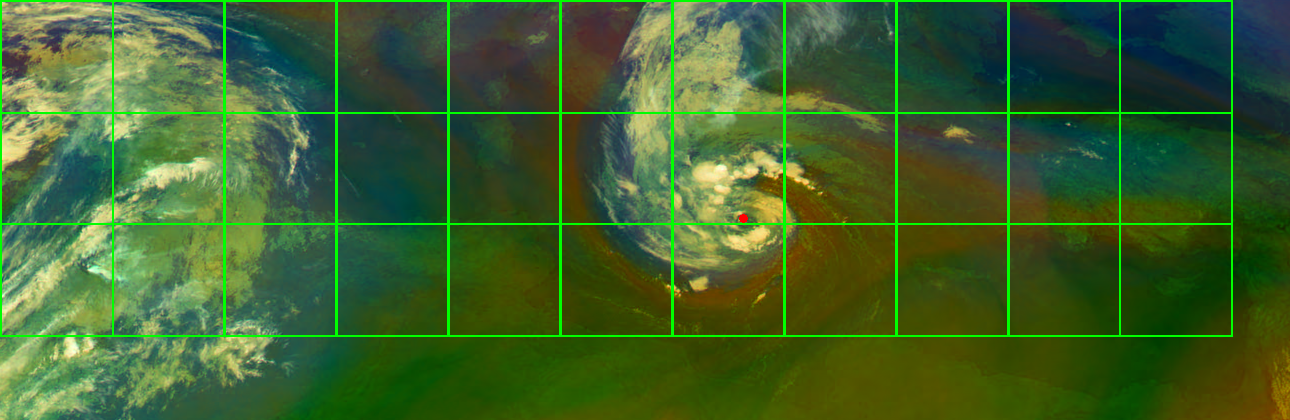

In [ ]:
center_px = (int(x_pix), int(y_pix))
#center_px = (600, 300)
# Disegniamo
out_img = draw_tiles_and_center(
    pil_image=img,
    cyclone_center=center_px
)
display(out_img)

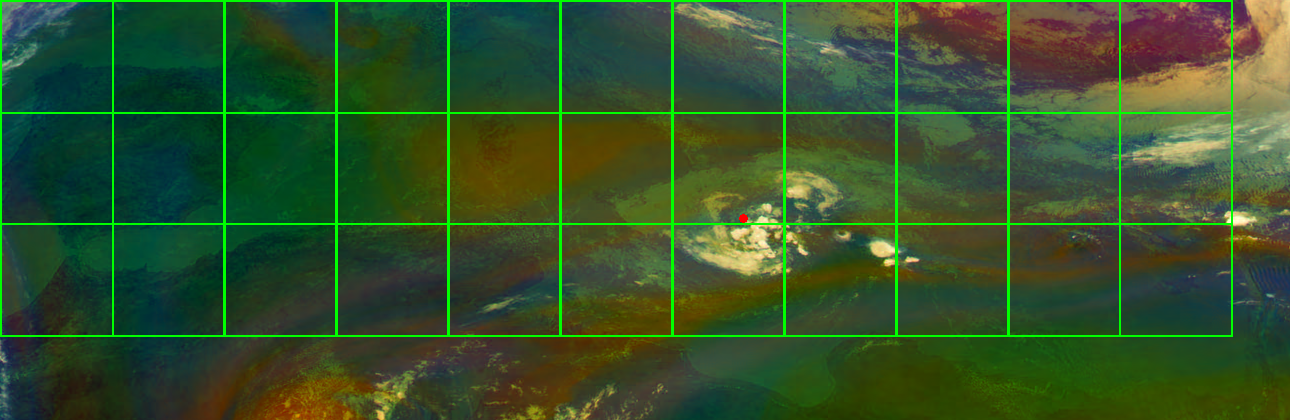

In [ ]:
center_px = (int(x_pix), int(y_pix))
#center_px = (600, 300)
# Disegniamo
out_img = draw_tiles_and_center(
    pil_image=img_trixie,
    cyclone_center=center_px
)
display(out_img)

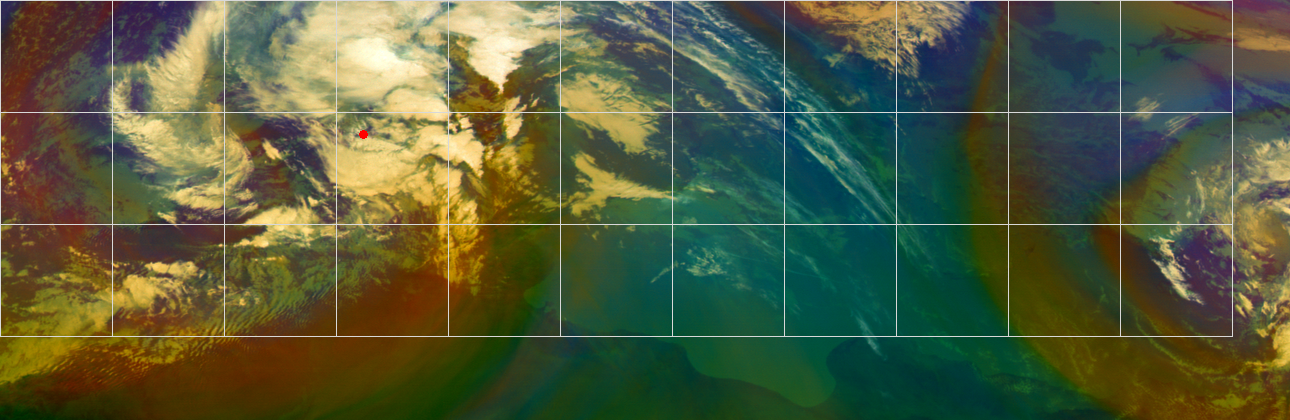

In [ ]:
center_px = (int(x_pix), int(y_pix))
#center_px = (600, 300)
# Disegniamo
out_img = draw_tiles_and_center(
    pil_image=img_rolf,
    cyclone_center=center_px
)
display(out_img)

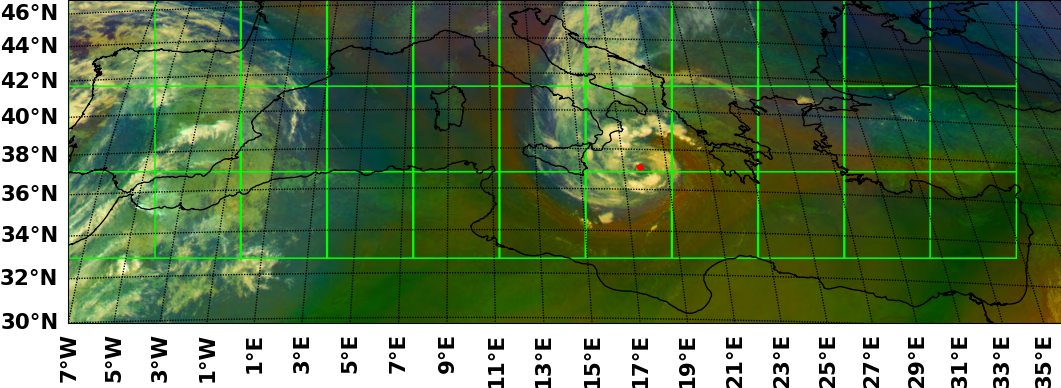

In [ ]:
plot_image(out_img, basemap_obj, draw_parallels_meridians=True)

### Etichettatura tiles

In [ ]:
lat, lon = df_candidates[['lat', 'lon']].values[0]
lat,lon

(37.069, 17.782)

In [ ]:
out_img = draw_tiles_and_center(
    pil_image=img,
    cyclone_center=center_px,
    labeled_tiles_offsets=labeled_tiles_offsets
)

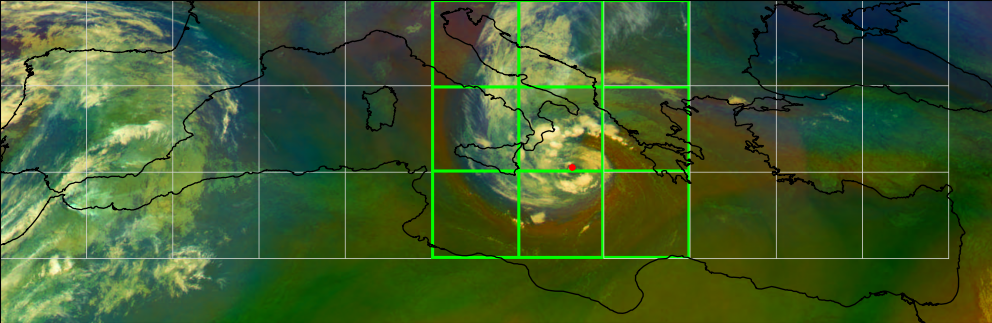

In [ ]:
plot_image(out_img, basemap_obj, draw_parallels_meridians=False)

# Etichettatura dataset

In [2]:
from medicane_utils.load_files import load_all_images, get_all_cyclones

In [3]:
tracks_df = get_all_cyclones()
sorted_metadata_files = load_all_images(input_dir = "../fromgcloud")

Available Medicanes for training: ['Rolf' 'Ilona' 'Qendresa' 'Trixie' 'Numa' 'Zorbas' 'Ianos']
117764 files loaded.


In [4]:
tracks_df['Medicane'].unique()

array([None, 'Rolf', 'Ilona', 'Qendresa', 'Trixie', 'Numa', 'Zorbas',
       'Ianos'], dtype=object)

In [ ]:
#display(tracks_df[2320:2340])
#display(tracks_df[3030:3050])

In [4]:
#sorted_metadata_files[2000:2001]

In [ ]:
df_data = labeled_tiles_from_metadatafiles(sorted_metadata_files, tracks_df)
df_data.shape

In [14]:
df_data = pd.read_csv("all_data.csv", dtype={
        "path": 'string',
        "tile_offset_x": 'int16',
        "tile_offset_y": 'int16',
        "label": 'category',
        "lat": 'float32',
        "lon": 'float32',
        "x_pix": 'Int16',
        "y_pix": 'Int16',
        "name": 'string'
    }, parse_dates=['datetime'])

In [15]:
df_data.shape

(2355280, 11)

In [16]:
mask_rolf = df_data['name'] == 'Rolf'
df_data_rolf = df_data[mask_rolf]

mask_ilona = df_data['name'] == 'Ilona'
df_data_ilona = df_data[mask_ilona]

mask_qendresa = df_data['name'] == 'Qendresa'
df_data_qendresa = df_data[mask_qendresa]

mask_trixie = df_data['name'] == 'Trixie'
df_data_trixie = df_data[mask_trixie]

mask_numa = df_data['name'] == 'Numa'
df_data_numa = df_data[mask_numa]

mask_ianos = df_data['name'] == 'Ianos'
df_data_ianos = df_data[mask_ianos]

In [23]:
df_data_rolf

Unnamed: 0                                         path  \
24240       24240  ../fromgcloud/airmass_rgb_20111105_0500.png   
24241       24241  ../fromgcloud/airmass_rgb_20111105_0500.png   
24242       24242  ../fromgcloud/airmass_rgb_20111105_0500.png   
24243       24243  ../fromgcloud/airmass_rgb_20111105_0500.png   
24244       24244  ../fromgcloud/airmass_rgb_20111105_0500.png   
...           ...                                          ...   
49675       49675  ../fromgcloud/airmass_rgb_20111109_1455.png   
49676       49676  ../fromgcloud/airmass_rgb_20111109_1455.png   
49677       49677  ../fromgcloud/airmass_rgb_20111109_1455.png   
49678       49678  ../fromgcloud/airmass_rgb_20111109_1455.png   
49679       49679  ../fromgcloud/airmass_rgb_20111109_1455.png   

                 datetime  tile_offset_x  tile_offset_y label    lat   lon  \
24240 2011-11-05 05:00:00              0              0     0    NaN   NaN   
24241 2011-11-05 05:00:00            112              0     1  42.34  1.05   
24242 2011-11-05 05:00:00            224              0     1  42.34  1.05   
24243 2011-11-05 05:00:00            336              0     0    NaN   NaN   
24244 2011-11-05 05:00:00            448              0     0    NaN   NaN   
...                   ...            ...            ...   ...    ...   ...   
49675 2011-11-09 14:55:00            560            112     0    NaN   NaN   
49676 2011-11-09 14:55:00            672            112     0    NaN   NaN   
49677 2011-11-09 14:55:00            784            112     0    NaN   NaN   
49678 2011-11-09 14:55:00            896            112     0    NaN   NaN   
49679 2011-11-09 14:55:00           1008            112     0    NaN   NaN   

       x_pix  y_pix  name            dt_floor  
24240   <NA>   <NA>  Rolf 2011-11-05 05:00:00  
24241    287     89  Rolf 2011-11-05 05:00:00  
24242    287     89  Rolf 2011-11-05 05:00:00  
24243   <NA>   <NA>  Rolf 2011-11-05 05:00:00  
24244   <NA>   <NA>  Rolf 2011-11-05 05:00:00  
...      ...    ...   ...                 ...  
49675   <NA>   <NA>  Rolf 2011-11-09 14:00:00  
49676   <NA>   <NA>  Rolf 2011-11-09 14:00:00  
49677   <NA>   <NA>  Rolf 2011-11-09 14:00:00  
49678   <NA>   <NA>  Rolf 2011-11-09 14:00:00  
49679   <NA>   <NA>  Rolf 2011-11-09 14:00:00  

[25440 rows x 12 columns]

In [18]:
len(df_data_rolf), len(df_data_ilona), len(df_data_qendresa), len(df_data_trixie), len(df_data_numa), len(df_data_ianos), 

(25440, 0, 32880, 31920, 28080, 39120)

In [19]:
def sub_select_group_df(df):
    df['dt_floor'] = df['datetime'].dt.floor('H')
    mask = df['datetime'] == df['dt_floor']
    df_filtered = df[mask]
    grouped = df_filtered.groupby("path", dropna=False)
    return grouped
    

In [20]:
g_rolf = sub_select_group_df(df_data_rolf)
g_qendresa = sub_select_group_df(df_data_qendresa)
g_trixie = sub_select_group_df(df_data_trixie)
g_numa = sub_select_group_df(df_data_numa)
g_ianos = sub_select_group_df(df_data_ianos)

In [ ]:
# Creiamo un raggruppamento per singola immagine
grouped = df_data_filtered.groupby("path", dropna=False)
img, g = list(grouped)[0]

In [18]:
# per rolf
img, g = list(g_rolf)[1]

In [22]:
g[['x_pix','y_pix']].value_counts()

x_pix  y_pix
287    89       2
Name: count, dtype: int64

In [23]:
center_px_list = g[['x_pix','y_pix']].value_counts().index.values


In [24]:
#g['label']#.values

In [21]:
def create_labeled_images_with_tiles(df_grouped, nome_gif):
# in ogni group abbiamo una sola immagine (un istante temporale)
# e tutte le tiles con le rispettive label. 
# possiamo avere più cicloni con le rispettive coordinate, da trovare uniche, perché si ripetono in tutte le tiles vicine
    lista_immagini = []
    for path_img, group_df in df_grouped:
        # Apriamo l'immagine
        img = Image.open(path_img)#.convert("RGB")
        #center_px_list = (x_pix, y_pix)
        center_px_list = group_df[['x_pix','y_pix']].value_counts().index.values
        #labeled_tiles_offsets = get_tile_labels(lat, lon)
        labeled_tiles_offsets = group_df['label'].values
        
        # Disegniamo
        default_offsets = calc_tile_offsets()
        out_img = draw_tiles_and_center(img, default_offsets,
        cyclone_centers=center_px_list,
        labeled_tiles_offsets=labeled_tiles_offsets
        )
        pi_img = plot_image(out_img, basemap_obj, latcorners, loncorners, draw_parallels_meridians=True)
        lista_immagini.append(pi_img)
        #display(out_img)
    
    lista_immagini[0].save(nome_gif, save_all=True, append_images=lista_immagini[1:], duration=200, loop=0)


In [22]:
create_labeled_images_with_tiles(g_rolf, 'rolf2.gif')

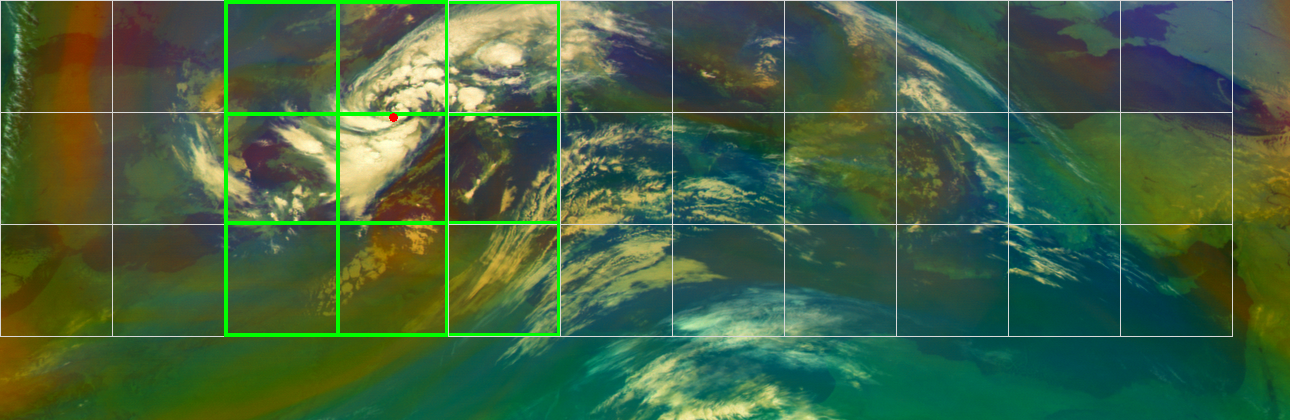

In [ ]:
create_labeled_images_with_tiles(g_qendresa, 'qendresa.gif')

In [ ]:
# testare per un ciclone e un medicane
# accuracy sul training test